# Load dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir data
!cp '/content/drive/My Drive/C1-P1_Train_Dev_fixed.zip' .
# !cp '/content/drive/My Drive/weights_collect.zip' .

In [0]:
%%capture
!unzip C1-P1_Train_Dev_fixed.zip -d '/content/data/' 
# !unzip weights_collect.zip -d '/content/' 

In [0]:
!ls data/C1-P1_Train_Dev_fixed 

C1-P1_Dev  C1-P1_Train	dev.csv  train.csv


In [0]:
!ls weights_collect

densenet.h5  efficientnetb4.h5	efficientnetb5.h5  efficientnetb7.h5


# Pipeline

In [0]:
!pip install -q efficientnet

In [0]:
import os 
import math, re, gc
import numpy as np 
import pandas as pd
import pickle
from datetime import datetime, timedelta
import tensorflow as tf
import efficientnet.tfkeras as efn
import tensorflow.keras.layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
import gc
import tensorflow_addons as tfa

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score

import seaborn as sns
from matplotlib import pyplot as plt

print('TensorFlow version', tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

TensorFlow version 2.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print('Replicas:', strategy.num_replicas_in_sync)

Running on TPU grpc://10.45.47.186:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.45.47.186:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.45.47.186:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Replicas: 8


In [0]:
NUM_CLASSES = 3
EPOCHS = 5
IMAGE_SIZE = [512, 512] 
BATCH_SIZE = 4 * strategy.num_replicas_in_sync

In [0]:
DATA_PATH = 'data/C1-P1_Train_Dev_fixed'
TRAINING_LABEL = pd.read_csv(DATA_PATH +'/train.csv')
DEV_LABEL = pd.read_csv(DATA_PATH +'/dev.csv')
STEPS_PER_EPOCH = len(TRAINING_LABEL)*0.8// BATCH_SIZE

In [0]:
tr_tfrecord_file   = 'gs://cloud_image_dat/aimongo/train.tfrecords'
val_tfrecord_file  = 'gs://cloud_image_dat/aimongo/val.tfrecords'
dev_tfrecord_file  = 'gs://cloud_image_dat/aimongo/dev.tfrecords'

In [0]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        #"class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "label": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    #label = tf.cast(example['class'], tf.int32)
    label = tf.one_hot(tf.cast(example['label'], tf.int32),NUM_CLASSES)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['image_name']
    return image, idnum # returns a dataset of image(s)

In [0]:
def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

# Data Augmentation

In [0]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

In [0]:
def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)

    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label

# Dataset Helper

In [0]:
def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(do_aug=True):
    dataset = load_dataset(tr_tfrecord_file, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    if do_aug: 
      dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(val_tfrecord_file, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(dev_tfrecord_file, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

In [0]:
def build_lrfn(lr_start=0.00001, lr_max=0.000075, 
               lr_min=0.000001, lr_rampup_epochs=20, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

In [0]:
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [0]:
model1_checkpoint_callback = ModelCheckpoint(
    filepath='efficientnetb7.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model2_checkpoint_callback = ModelCheckpoint(
    filepath='efficientnetb4.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model3_checkpoint_callback = ModelCheckpoint(
    filepath='efficientnetb5.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model4_checkpoint_callback = ModelCheckpoint(
    filepath='densenet.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

model_out_checkpoint_callback = ModelCheckpoint(
    filepath='out.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Focal Loss

In [0]:
def categorical_focal_loss(gamma=2., alpha=.25):
    """
    Softmax version of focal loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy, Default=2.0 as mentioned in the paper
      gamma -- focusing parameter for modulating factor (1-p), Default=0.25 as mentioned in the paper
      
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Sum the losses in mini_batch
        return K.sum(loss, axis=1)

    return categorical_focal_loss_fixed

In [0]:
train_dataset = get_training_dataset()
valid_dataset = get_validation_dataset()

# Image Display

In [0]:
def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else str(label)
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()


In [0]:
def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

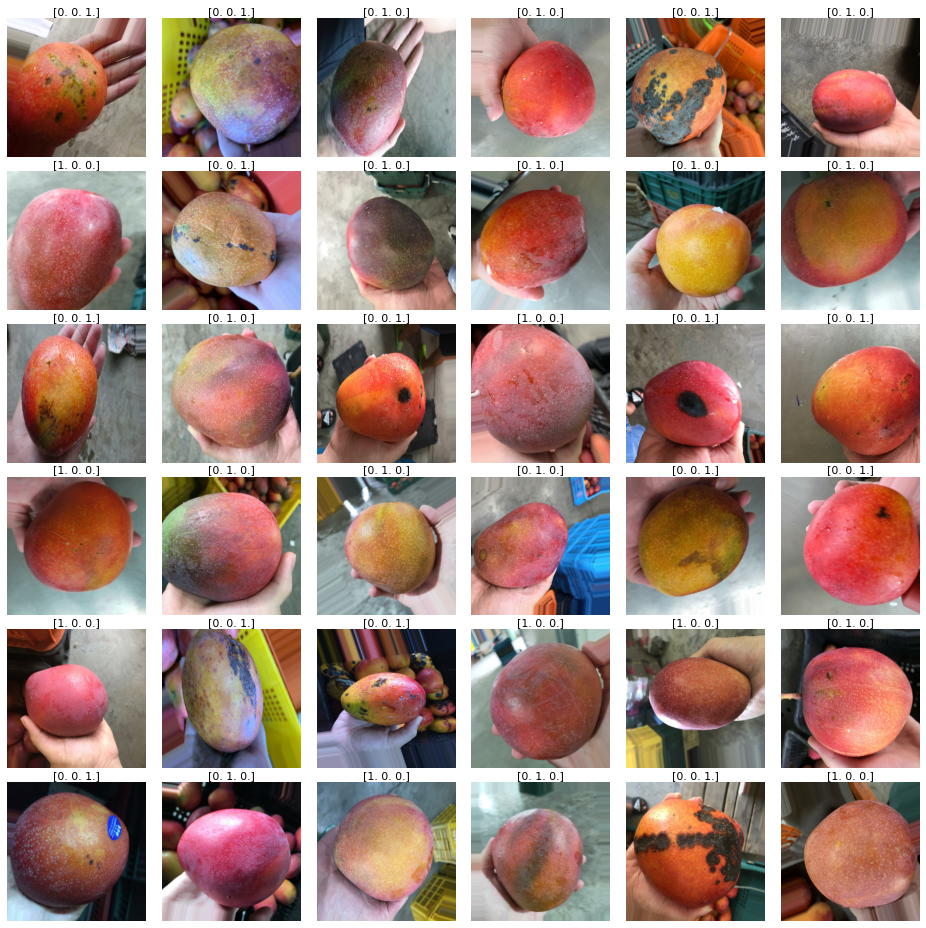

In [0]:
# train_batch = iter(train_dataset.unbatch().batch(40))
# display_batch_of_images(next(train_batch))

# Model Training

In [0]:
with strategy.scope():
    model1 = tf.keras.Sequential([
        efn.EfficientNetB7(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        L.GlobalAveragePooling2D(),
        L.Dense(NUM_CLASSES, activation='softmax')
    ])
    model1.compile(
        optimizer='adam',
        loss = [categorical_focal_loss(gamma=2., alpha=.25)],
        metrics=['accuracy']
    )
    model1.summary()


258441216/258434480 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 16, 16, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2560)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7683      
Total params: 64,105,363
Trainable params: 63,794,643
Non-trainable params: 310,720
_________________________________________________________________


In [0]:
with strategy.scope():
    enet = efn.EfficientNetB4(
        input_shape=(*IMAGE_SIZE, 3),
        weights='noisy-student',
        include_top=False
    )

    model2 = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ]) 

    model2.compile(
            optimizer='adam',
            loss = [categorical_focal_loss(gamma=2., alpha=.25)],
            metrics=['accuracy']
            )
    model2.summary()


71680000/71678424 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 16, 16, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 5379      
Total params: 17,679,195
Trainable params: 17,553,995
Non-trainable params: 125,200
_________________________________________________________________


In [0]:
with strategy.scope():
    enet = efn.EfficientNetB6(
        input_shape=(*IMAGE_SIZE, 3),
        weights='noisy-student',
        include_top=False
    )

    model3 = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ]) 

model3.compile(
            optimizer='adam',
            loss = [categorical_focal_loss(gamma=2., alpha=.25)],
            metrics=['accuracy']
            )
model3.summary()


165232640/165226952 [==============================] - 2s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6915      
Total params: 40,967,051
Trainable params: 40,742,619
Non-trainable params: 224,432
_________________________________________________________________


In [0]:
with strategy.scope():
    desnet=tf.keras.applications.DenseNet201(
        weights='imagenet',
        include_top=False
      
    )
    model4 = tf.keras.Sequential([
        desnet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ]) 

    model4.compile(
                optimizer='adam',
                loss = [categorical_focal_loss(gamma=2., alpha=.25)],
                metrics=['accuracy']
                )
    model4.summary()


74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, None, None, 1920)  18321984  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1920)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 5763      
Total params: 18,327,747
Trainable params: 18,098,691
Non-trainable params: 229,056
_________________________________________________________________


# Fitting

In [0]:
# history1 = model1.fit(
#     train_dataset, 
#     epochs=EPOCHS, 
#     callbacks=[lr_schedule, model1_checkpoint_callback],
#     steps_per_epoch=STEPS_PER_EPOCH,
#     validation_data=valid_dataset
# )

In [0]:
# history2 = model2.fit(
#     train_dataset, 
#     epochs=EPOCHS, 
#     callbacks=[lr_schedule, model2_checkpoint_callback],
#     steps_per_epoch=STEPS_PER_EPOCH,
#     validation_data=valid_dataset
# )

In [0]:
# history3 = model3.fit(
#     train_dataset, 
#     epochs=EPOCHS, 
#     callbacks=[lr_schedule, model3_checkpoint_callback],
#     steps_per_epoch=STEPS_PER_EPOCH,
#     validation_data=valid_dataset
# )

In [0]:
# history4 = model4.fit(
#     train_dataset, 
#     epochs=EPOCHS, 
#     callbacks=[lr_schedule, model4_checkpoint_callback],
#     steps_per_epoch=STEPS_PER_EPOCH,
#     validation_data=valid_dataset
# )


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/5
140/140 [==============================] - 85s 605ms/step - loss: 0.1119 - accuracy: 0.5275 - val_loss: 0.0954 - val_accuracy: 0.5375 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 3.95e-05.
Epoch 2/5
140/140 [==============================] - 56s 397ms/step - loss: 0.0699 - accuracy: 0.6871 - val_loss: 0.0467 - val_accuracy: 0.7714 - lr: 3.9500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 6.9e-05.
Epoch 3/5
140/140 [==============================] - 51s 364ms/step - loss: 0.0598 - accuracy: 0.7299 - val_loss: 0.0644 - val_accuracy: 0.6955 - lr: 6.9000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 9.849999999999998e-05.
Epoch 4/5
140/140 [==============================] - 51s 364ms/step - loss: 0.0544 - accuracy: 0.7511 - val_loss: 0.0698 - val_accuracy: 0.6857 - lr: 9.8500e-05

Epoch 00005: LearningRateScheduler reducing learning rate 

# For Inference

In [0]:
model1.load_weights("weights_collect/efficientnetb7.h5")
model2.load_weights("weights_collect/efficientnetb4.h5")
model3.load_weights('weights_collect/efficientnetb5.h5')
model4.load_weights('weights_collect/densenet.h5')

# Get and Train Meta classifier

In [0]:
model11 = tf.keras.Sequential()
for layer in model1.layers[:-2]:
    model11.add(layer)
for layer in model11.layers:
    layer.trainable = False
model22 = tf.keras.Sequential()
for layer in model2.layers[:-2]:
    model22.add(layer)
for layer in model22.layers:
    layer.trainable = False
model33 = tf.keras.Sequential()
for layer in model3.layers[:-2]:
    model33.add(layer)
for layer in model33.layers:
    layer.trainable = False
model44 = tf.keras.Sequential()
for layer in model4.layers[:-2]:
    model44.add(layer)
for layer in model44.layers:
    layer.trainable = False

In [0]:
with strategy.scope():
    
    x = tf.keras.Input(shape = (*IMAGE_SIZE, 3))
    x1 = model11(x)
    x2 = model22(x)
    x3 = model33(x)
    x4 = model44(x)
    x5 = tf.keras.layers.concatenate([x1, x2, x3, x4], axis = 3)
    x6 = tf.keras.layers.GlobalAveragePooling2D()(x5)
    x6 = tf.keras.layers.Dropout(0.75)(x6)
    x6 = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x6)
    out = tf.keras.Model(inputs = x, outputs = x6)

out.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = [categorical_focal_loss(gamma=2., alpha=.25)],
    metrics=['accuracy']
)
out.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 16, 16, 2560) 64097680    input_5[0][0]                    
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 16, 16, 1792) 17673816    input_5[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 16, 16, 2304) 40960136    input_5[0][0]                    
______________________________________________________________________________________________

In [0]:
history_out = out.fit(
    train_dataset, 
    epochs=EPOCHS, 
    callbacks=[lr_schedule, model_out_checkpoint_callback],
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    shuffle=True
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/5
140/140 [==============================] - 189s 1s/step - loss: 0.1427 - accuracy: 0.4614 - val_loss: 0.0780 - val_accuracy: 0.6330 - lr: 1.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 3.95e-05.
Epoch 2/5
140/140 [==============================] - 92s 661ms/step - loss: 0.0930 - accuracy: 0.5846 - val_loss: 0.0467 - val_accuracy: 0.7437 - lr: 3.9500e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 6.9e-05.
Epoch 3/5
140/140 [==============================] - 93s 668ms/step - loss: 0.0621 - accuracy: 0.7025 - val_loss: 0.0386 - val_accuracy: 0.7777 - lr: 6.9000e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 9.849999999999998e-05.
Epoch 4/5
140/140 [==============================] - 93s 666ms/step - loss: 0.0536 - accuracy: 0.7467 - val_loss: 0.0403 - val_accuracy: 0.7857 - lr: 9.8500e-05

Epoch 00005: LearningRateScheduler reducing learning rate to

In [0]:
out.load_weights('out.h5')

# Model Prediction

In [0]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = out.predict(test_images_ds)

Computing predictions...


In [0]:
print('Generating submission file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(len(DEV_LABEL)))).numpy().astype('U') # all in one batch

Generating submission file...


In [0]:
LABEL_MAP = {0:'A',1:'B',2:'C'}
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.argmax(probabilities,axis=1)})
pred_df['target'] = pred_df['target'].map(LABEL_MAP)
pred_df.columns = ['image_id','target']
pred_df.head()

,image_id,target
0,06791.jpg,C
1,06724.jpg,B
2,03995.jpg,C
3,04649.jpg,C
4,00760.jpg,C


In [0]:
df = pd.merge(DEV_LABEL,pred_df,how='left',on='image_id')
df.columns= ['image_ids','y_true','y_pred']

In [0]:
accu = accuracy_score(df['y_true'],df['y_pred'])
print('Accuracy score:{}'.format(accu))

Accuracy score:0.8475


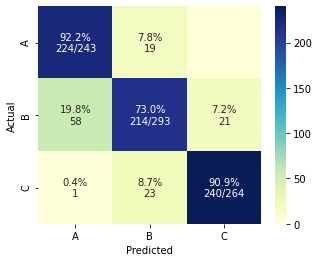

In [0]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(3,3)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax,cmap="YlGnBu")
    #plt.savefig(filename)
    plt.show()

cm_analysis(df['y_true'],df['y_pred'], ['A','B','C'], ymap=None, figsize=(5,4))

# DownLoad weight

In [0]:
!ls

C1-P1_Train_Dev_fixed.zip  drive     out.h5	  weights_collect
data			   __MACOSX  sample_data  weights_collect.zip


In [0]:
from google.colab import files
files.download('densenet.h5') 